# Titanic - Doing it right! Pipeline and Evaluation
### Introduction
Hi! Welcome to this notebook. I will walk you through several stages regarding the Titanic machine learning competition provided by kaggle. The focus lies on two important concepts many people get wrong:
* Correct training in connection to **Data Leakage**
* Correct evaluation in connection to Train Set, Validation Set and Test Set

For example headlines of other notebooks like "Titanic - Achieve 80% / 90% Accuracy" are simply wrong, but more on that in the training and evaluation part.

Please note that I am not a professional or have detailed explanations for most of the techniques I try to describe! If you want to learn more I strongly recommend the book **"Data Science for Business"** by Foster Provost and Tom Fawcett.

### Workflow
1. Libraries
2. Acquire Data
3. Analysis
4. Preprocessing
    * Feature Engineering
    * Pipeline
5. Training
6. Evaluation
7. Prediction

# Libraries
Besides the standard libraries like numpy or pandas we use multiple libraries to build our pipeline and acquire our model.

In [1]:
#Path
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#Standard
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # data visualization

#Preprocessing
from sklearn.impute import KNNImputer # nearest neighbor imputer
from sklearn.preprocessing import StandardScaler # scaler

#Pipeline
from sklearn.pipeline import Pipeline # pipeline
from sklearn.base import BaseEstimator, TransformerMixin # custom pipeline methods
from sklearn.compose import ColumnTransformer # pipeline unit

#Training
from sklearn.model_selection import train_test_split # train test split
from sklearn.ensemble import RandomForestClassifier # random forest model
from sklearn.ensemble import GradientBoostingClassifier # gradient boosting model
from sklearn.model_selection import GridSearchCV # grid search technique

#Evaluation
from sklearn.metrics import accuracy_score # evaluation method

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Acquire Data & General Information
We acquire the labelled Train Data (train_data in code) and unlabeled Test Data which we call the Score Set ('score_set' in code) to avoid confusions later on. We then look at the columns and data types, the first few lines of each set, and the general distribution of each column. It provides us with a general overview and a first insight into the data.
One important aspect is that both the Train Data and Score Set have the same columns and that a column has the same type in both sets.

In [2]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv") # Train Data
score_set = pd.read_csv("/kaggle/input/titanic/test.csv") # Score Set

One of the most important information sources is the description of the features provided by the challenge itself.

| Variable        | Definition           | Key  |
| ------------- |:-------------:| -----:|
| survival      | Survival      | 0 = No, 1 = Yes |
| pclass        | Ticket class  | 1 = 1st, 2 = 2nd, 3 = rd |
| sex           | Sex           |  |
| Age          | Age in years           |  |
| sibsp           | # of siblings / spouses aboard the Titanic         |  |
| parch          | # of parents / children aboard the Titanic          |  |
| ticket           | Ticket number           |  |
| fare           | Passenger fare           |  |
| cabin           | Cabin number           |  |
| embarked           | Port of Embarkation           | C = Cherbourg, Q = Queenstown, S = Southampton |

In [3]:
train_data.info() # Feature Information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
train_data.head() # First five rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train_data.describe(include='all') # Descriptive Statistics

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Moran, Miss. Bertha",male,NaN,NaN,NaN,CA. 2343,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [6]:
score_set.info() # Feature Information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [7]:
score_set.head() # First five rows

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [8]:
score_set.describe(include='all') # Descriptive Statistics

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,418.000000,418.000000,418,418,332.000000,418.000000,418.000000,418,417.000000,91,418
unique,NaN,NaN,418,2,NaN,NaN,NaN,363,NaN,76,3
top,NaN,NaN,"Bowen, Miss. Grace Scott",male,NaN,NaN,NaN,PC 17608,NaN,B57 B59 B63 B66,S
freq,NaN,NaN,1,266,NaN,NaN,NaN,5,NaN,3,270
mean,1100.500000,2.265550,NaN,NaN,30.272590,0.447368,0.392344,NaN,35.627188,NaN,NaN
std,120.810458,0.841838,NaN,NaN,14.181209,0.896760,0.981429,NaN,55.907576,NaN,NaN
min,892.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,996.250000,1.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,1100.500000,3.000000,NaN,NaN,27.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1204.750000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.500000,NaN,NaN


# Analysis
## Total distribution of each discrete variable
We can visualize the distribution of the discrete variables to look into the different possible values each can take and the distribution of these values. 

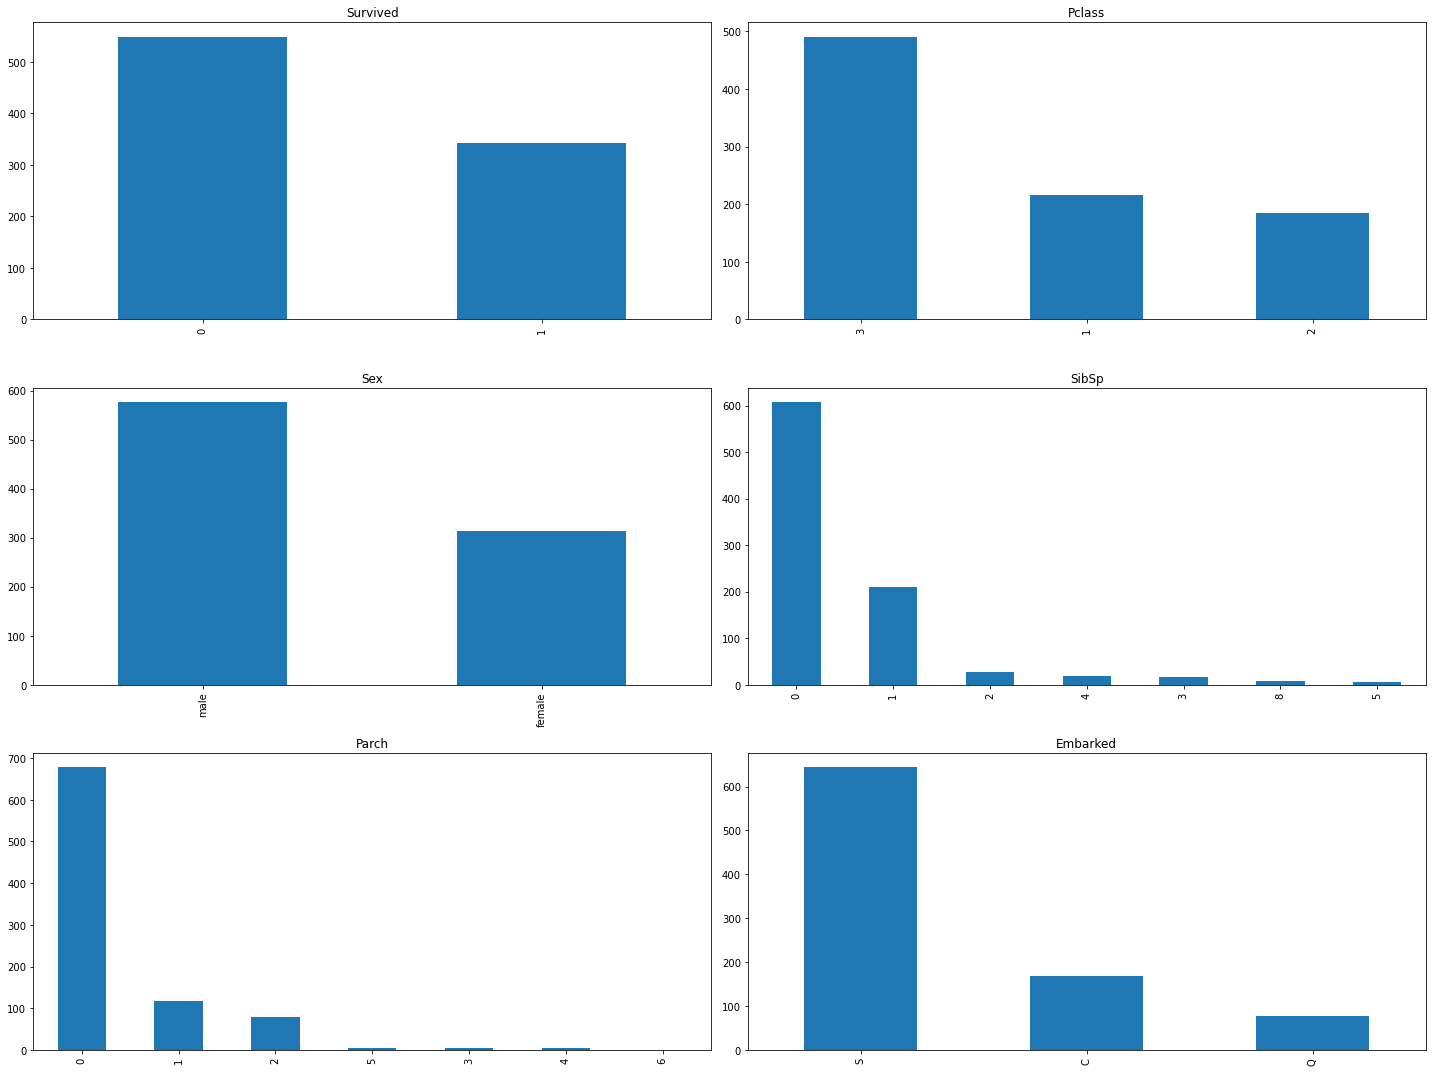

In [9]:
plt.figure(figsize=(20, 15))

# Survived Plot
plt.subplot(3, 2, 1)
train_data['Survived'].value_counts().plot(kind='bar')
plt.title('Survived')

# Pclass Plot
plt.subplot(3, 2, 2)
train_data['Pclass'].value_counts().plot(kind='bar')
plt.title('Pclass')

# Sex Plot
plt.subplot(3, 2, 3)
train_data['Sex'].value_counts().plot(kind='bar')
plt.title('Sex')

# Siblings and Spouses Plot
plt.subplot(3, 2, 4)
train_data['SibSp'].value_counts().plot(kind='bar')
plt.title('SibSp')

# Parents and Children Plot
plt.subplot(3, 2, 5)
train_data['Parch'].value_counts().plot(kind='bar')
plt.title('Parch')

# Embarked Plot
plt.subplot(3, 2, 6)
train_data['Embarked'].value_counts().plot(kind='bar')
plt.title('Embarked')

plt.tight_layout() 

Below we can see that the Ticket and Cabin column have a lot of unique values which we have to clean up later.

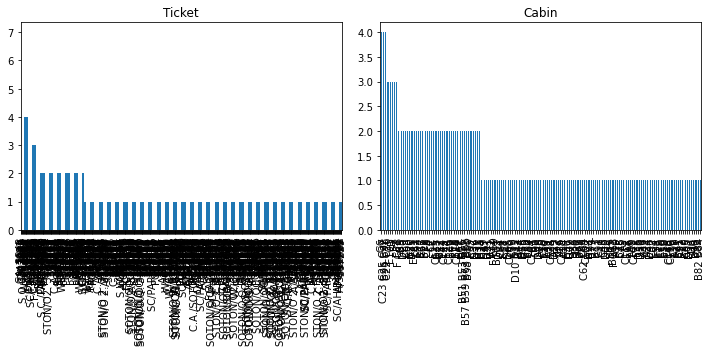

In [10]:
plt.figure(figsize=(10, 5))

# Ticket Plot
plt.subplot(1, 2, 1)
train_data['Ticket'].value_counts().plot(kind='bar')
plt.title('Ticket')

# Cabin Plot
plt.subplot(1, 2, 2)
train_data['Cabin'].value_counts().plot(kind='bar')
plt.title('Cabin')

plt.tight_layout() 

## Distribution for each continuous variable

We do the same for continuous variables to detect potential outliers. Age doesn't seem to have any outliers. Fare could have one at 500, however, a quick google search shows that the prices were as high as 4300$ meaning we have not an outlier here as well.

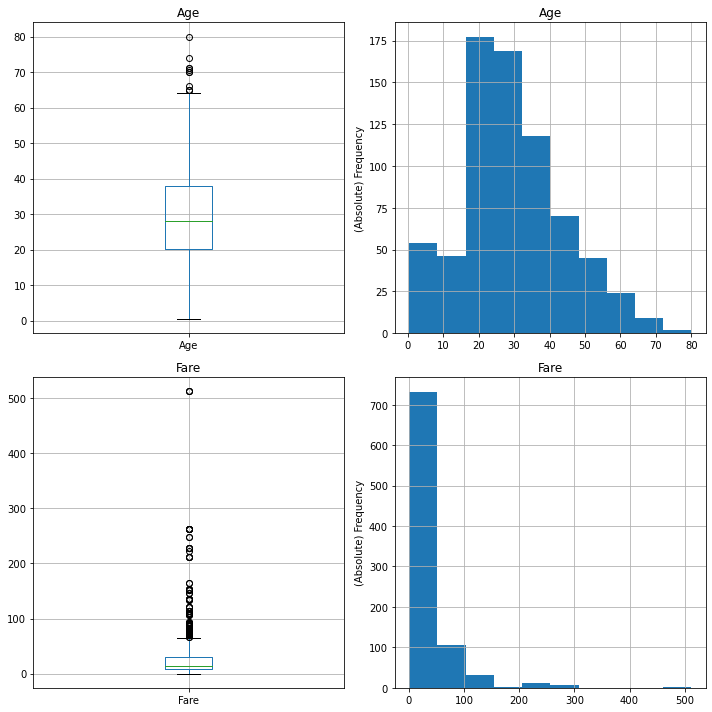

In [11]:
plt.figure(figsize=(10, 10))

# Age Boxplot
plt.subplot(2, 2, 1)
train_data.boxplot(column=['Age'])
plt.title("Age")

# Age Histogram
plt.subplot(2, 2, 2)
train_data['Age'].hist()
plt.title("Age")
plt.ylabel("(Absolute) Frequency")

# Fare Boxplot
plt.subplot(2, 2, 3)
train_data.boxplot(column=['Fare'])
plt.title("Fare")
plt.subplot(2, 2, 4)

# Fare Histogram
train_data['Fare'].hist()
plt.title("Fare")
plt.ylabel("(Absolute) Frequency")

plt.tight_layout() 

## Calculate missing data for Train Data and Score Set
Calculating the percentages of missing data for each column we see that we have to impute values for the Age and Cabin column. The Cabin column could even be dropped as it has a big percentage of its values missing.

In [12]:
# Missing Data Train Data
missing_data_train = pd.DataFrame({'total_missing': train_data.isnull().sum(), 'perc_missing': (train_data.isnull().sum()/891)*100})
print('Missing Data Train Data \n',missing_data_train,'\n')

# Missing Data Score Set
missing_data_score = pd.DataFrame({'total_missing': score_set.isnull().sum(), 'perc_missing': (score_set.isnull().sum()/418)*100})
print('Missing Data Score Set \n',missing_data_score)

Missing Data Train Data 
              total_missing  perc_missing
PassengerId              0      0.000000
Survived                 0      0.000000
Pclass                   0      0.000000
Name                     0      0.000000
Sex                      0      0.000000
Age                    177     19.865320
SibSp                    0      0.000000
Parch                    0      0.000000
Ticket                   0      0.000000
Fare                     0      0.000000
Cabin                  687     77.104377
Embarked                 2      0.224467 

Missing Data Score Set 
              total_missing  perc_missing
PassengerId              0      0.000000
Pclass                   0      0.000000
Name                     0      0.000000
Sex                      0      0.000000
Age                     86     20.574163
SibSp                    0      0.000000
Parch                    0      0.000000
Ticket                   0      0.000000
Fare                     1      0.239234
Cabi

## Show distribution given Target variable
In correlation to the target variable, we can see for example that people that were in the first class and female had higher survival rates than others males or people travelling third class.

In [13]:
# Target Variable
Status = train_data['Survived']

# Correlation Pclass
train_data['Pclass'].value_counts()
pd.crosstab(Status, train_data['Pclass'], margins=True)
print(pd.crosstab(Status, train_data['Pclass'], margins=True, normalize='columns'),'\n')

# Correlation Sex
train_data['Sex'].value_counts()
pd.crosstab(Status, train_data['Sex'], margins=True)
print(pd.crosstab(Status, train_data['Sex'], margins=True, normalize='columns'),'\n')

# Correlation Parents and Children
train_data['Parch'].value_counts()
pd.crosstab(Status, train_data['Parch'], margins=True)
print(pd.crosstab(Status, train_data['Parch'], margins=True, normalize='columns'),'\n')

# Correlation Siblings and Spouses
train_data['SibSp'].value_counts()
pd.crosstab(Status, train_data['SibSp'], margins=True)
print(pd.crosstab(Status, train_data['SibSp'], margins=True, normalize='columns'),'\n')

# Correlation Embarked
train_data['Embarked'].value_counts()
pd.crosstab(Status, train_data['Embarked'], margins=True)
print(pd.crosstab(Status, train_data['Embarked'], margins=True, normalize='columns'),'\n')

Pclass          1         2         3       All
Survived                                       
0         0.37037  0.527174  0.757637  0.616162
1         0.62963  0.472826  0.242363  0.383838 

Sex         female      male       All
Survived                              
0         0.257962  0.811092  0.616162
1         0.742038  0.188908  0.383838 

Parch            0         1    2    3    4    5    6       All
Survived                                                       
0         0.656342  0.449153  0.5  0.4  1.0  0.8  1.0  0.616162
1         0.343658  0.550847  0.5  0.6  0.0  0.2  0.0  0.383838 

SibSp            0         1         2     3         4    5    8       All
Survived                                                                  
0         0.654605  0.464115  0.535714  0.75  0.833333  1.0  1.0  0.616162
1         0.345395  0.535885  0.464286  0.25  0.166667  0.0  0.0  0.383838 

Embarked         C        Q         S       All
Survived                                

## Plot correlation of variables
Pclass and Fare have the highest correlation to the target variable. One important point is that it doesn't matter if and how strong variables correlate if you want to predict something! It only matters if you want to explain certain phenomena influenced by variables.

Pclass        -0.338481
Age           -0.077221
SibSp         -0.035322
PassengerId   -0.005007
Parch          0.081629
Fare           0.257307
Survived       1.000000
dtype: float64


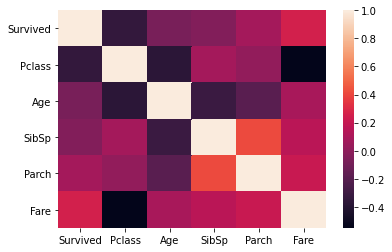

In [14]:
# Compute correlation matrix
corr = train_data.corr()

# Drop PassengerId
corr_adjusted = train_data.drop(columns=['PassengerId']).corr()

# Visualization of the correlation matrix with Seaborn library
import seaborn as sns
heat = sns.heatmap(corr_adjusted, 
            xticklabels=corr_adjusted.columns.values,
            yticklabels=corr_adjusted.columns.values)

# Correlation Values
print(train_data.corrwith(train_data["Survived"]).sort_values())

# Data Preprocessing

## Feature Engineering

For the Train Data and Score Set, we map the Sex column to numbers and create the Family Size and Is Alone Feature. For Family Size we take Siblings and Spouses column (SibSp) and the Parents and Children Column (Parch) and add one to it to generate the whole Family Size on the Titanic. If Family Size is 1 it means the person is travelling alone and we set Is Alone to one indicating Is Alone is true.

In [15]:
#Feature Engineering

#Train Data

#Map Sex to numbers
train_data['Sex'] = train_data['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

#Engineer FamiliySize feature
train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch'] + 1

#Engineer IsAlone feature
train_data['IsAlone'] = 0
train_data.loc[train_data['FamilySize'] == 1, 'IsAlone'] = 1

#Score Set

#Map Sex to numbers
score_set['Sex'] = score_set['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

#Engineer FamiliySize feature
score_set['FamilySize'] = score_set['SibSp'] + score_set['Parch'] + 1

#Engineer IsAlone feature
score_set['IsAlone'] = 0
score_set.loc[score_set['FamilySize'] == 1, 'IsAlone'] = 1

## Pipeline and Data Leakage
### General Important Concepts
Before we start to explaining **Pipelines** and **Data Leakage** we should look at the overall principles of Data Science and Predictive Modelling. In Data Science Projects often labelled **Train Data** and unlabeled **Test Data** (which we named Score Set) is given. The goal is to learn patterns from the Train Data and apply these learned patterns and rules to the Score Set to predict as best as possible the correct labels. Most simply we take the whole Train Data, learn the patterns and predict the labels of the Score Set. This is however a very bad way to do it because we have no information on how good our model performs. Sure we can just take our model and predict on the Train Data to get an accuracy score, but just let me show you some pictures from Wikimedia explaining the problem with that:

<img src="https://upload.wikimedia.org/wikipedia/commons/1/19/Overfitting.svg" width="300">

Chabacano, CC BY-SA 4.0 <https://creativecommons.org/licenses/by-sa/4.0>, via Wikimedia Commons

<img src="https://upload.wikimedia.org/wikipedia/commons/5/52/2d-epochs-overfitting.svg" width="300">

MartinThoma, CC0, via Wikimedia Commons

As you can see the Performance / Predictive Power on your Train Data gets better and better the more we train and the more complex our model gets, but on the Score Set, there is a point where the performance goes down. This is called **Overfitting** and a very very important concept. It shows that we memorize the Train Data too much and don't generalize any more. To avoid this we introduce a **Test Set**. A Test Set is a standalone part of the Train Data we don't train on but test the model after the training phase to get an unbiased evaluation of our model. We now have a Train Set and Test Set. Usually, it is around 20 % of the Train Data, but it depends on the size of the data. If the performance on the Test Set gets down we stop training as we've found the sweet spot with the highest performance on unseen data. 

What if we want to tune the model in the training phase? Trying different parameters and techniques? If we evaluate all these possible configurations on the Test Set we no longer have an unbiased data set on which we can evaluate the final model with the best parameters. We simply create another standalone set of the Train Data, the **Validation Set**. It is usually around 20 % of the Train Data we have left after have it split into Train Set and Test Set. The logical workflow is as follows. Split the Train Data into Train Set, Validation Set and Test set. Train the model on our Train Set and try different parameters. For each model, the configuration takes the performance on the Validation Set. After training, take the best model configuration given the different performances on the Validation Set and evaluate the final model on the Test Set to get an unbiased opinion on how well our final model predicts unseen data.

<img src="https://upload.wikimedia.org/wikipedia/commons/b/bb/ML_dataset_training_validation_test_sets.png" width="600">

Km121220, CC BY-SA 4.0 <https://creativecommons.org/licenses/by-sa/4.0>, via Wikimedia Commons

### Data Leakage
To get evaluation values that are the closest to how our model will perform on unseen data we should take a look at **Data Leakage**. Data leakage describes if the information of the Test Set and Validation Set leak into our Train Set and model, meaning both sets are not 100 % unseen any longer. A typical example is if we calculate the mean of the whole Train Data and impute it where data is missing. The right way to do it would be to split the Train Data into Train Set, Validation Set and Test Set, calculate the mean of the only Train Set and impute it into the three sets where data is missing. In this way, there is no information flow from the Validation Set and Test Set into the Train Set. You should always think of the information you derive and compute for the Train Data as a one-way lane from the Train Set to the Validation Set and Test Set.
### The Pipeline and Cross-Fold-Validation
A **Pipeline** can be seen as a set of sequential steps transforming given data when calling the Pipeline. The transformations can be normalizations, imputations or custom mappings to other datatypes. Why are we using it? To prevent data leakage when using another method: **Cross-Fold-Validation**. Using Cross-Fold-Validation we part the Train Data in a Train Set and Test Set. The method then parts the Train Set into n-folds (like 5 or 10), trains on n-1 folds and validates on the last fold. It does that n-times for every possible train folds - validation fold configuration and takes the mean of all calculated evaluation metrics. Imagine we have three folds and want to impute missing data. To prevent Data Leakage we have to calculate the mean of a column from the first two folds and impute the solution in all three folds. We then train and evaluate. The next step is to do it again, but taking the second and third fold for calculation and training and impute and evaluate on the first and so on. This would mean a lot of code. With a pipeline, we can define the data preprocessing before, pass the pipeline to Cross-Fold-Validation where the preprocessing is run automatically for every single fold configuration. In short: We prevent Data Leakage!

I could only find a picture of Cross-Fold-Validation in another language than English on Wikimedia. The first block 'conjunto de dados' stands here for the Train Set from option 'A' in the picture above. As you can see the Train Set gets parted into four-folds. The blue folds are the Train Set for the respective fold, the yellow folds the Validation Set for the respective fold.

<img src="https://upload.wikimedia.org/wikipedia/commons/5/5c/K-Fold_Cross-Validation.png" width="600">

Leomaurodesenv, CC BY-SA 4.0 <https://creativecommons.org/licenses/by-sa/4.0>, via Wikimedia Commons

### Custom Methods
At first, we look at some custom methods for our Pipeline transforming the columns Fare, Age, Embarked, Cabin and Name. In short for the Fare and Age column we use binning to introduce non-linearity. The Embarked, Cabin and Name columns get mapped to numbers. Each class consists of a init, fit and transform method. While we can ignore the init method, the fit method extracts and saves information of the Train Set. This information is then used to transform the Train Set and Validation Set inside the transform method. 

#### Fare Feature
First, we look at the Fare Feature. We part the feature beforehand into equal size buckets and use this information to encode the feature to introduce non-linearity. You should notice something here! The way I did it is a case of Data Leakage. We calculate the bucket boundaries on the whole Train Data and not just on the Train Set after the split. The right way to do it would be inside the fit method inside the FareFeatureTransfomer class below, but I didn't find a way to extract and save the boundary information (yet).

In [16]:
# Binning
pd.qcut(train_data['Fare'], 4).unique()

[(-0.001, 7.91], (31.0, 512.329], (7.91, 14.454], (14.454, 31.0]]
Categories (4, interval[float64]): [(-0.001, 7.91] < (7.91, 14.454] < (14.454, 31.0] < (31.0, 512.329]]

In [17]:
# Transform Fare Feature
class FareFeatureTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        None
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, x):
        
        # Transform to DataFrame
        if isinstance(x, np.ndarray):
            x = pd.DataFrame(x, columns=['Fare'])
        
        # Map to Bucket Boundaries
        x.loc[ x['Fare'] <= 7.91, 'Fare'] = 0
        x.loc[(x['Fare'] > 7.91) & (x['Fare'] <= 14.454), 'Fare'] = 1
        x.loc[(x['Fare'] > 14.454) & (x['Fare'] <= 31), 'Fare']   = 2
        x.loc[ x['Fare'] > 31, 'Fare'] = 3    
        
        return x

#### Age Feature
This is the same as above. The only difference is that the buckets are of equal width and not of equal size.

In [18]:
# Binning
pd.cut(train_data['Age'], 5).unique()

[(16.336, 32.252], (32.252, 48.168], NaN, (48.168, 64.084], (0.34, 16.336], (64.084, 80.0]]
Categories (5, interval[float64]): [(0.34, 16.336] < (16.336, 32.252] < (32.252, 48.168] < (48.168, 64.084] < (64.084, 80.0]]

In [19]:
# Transform Age Feature
class AgeFeatureTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        None
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, x):
        
        # Transform to DataFrame
        if isinstance(x, np.ndarray):
            x = pd.DataFrame(x, columns=['Age'])
        
        # Map to Bucket Boundaries
        x.loc[ x['Age'] <= 16, 'Age'] = 0
        x.loc[(x['Age'] > 16) & (x['Age'] <= 32), 'Age'] = 1
        x.loc[(x['Age'] > 32) & (x['Age'] <= 48), 'Age'] = 2
        x.loc[(x['Age'] > 48) & (x['Age'] <= 64), 'Age'] = 3
        x.loc[ x['Age'] > 64, 'Age'] = 4  
        
        return x

#### Embarked Feature
This class performs a simple mapping operation for each of the possible values of the Embarked Feature. We encode the missing values as well to be able to use the KNN imputation later on.

In [20]:
# Transform Embarked Feature
class EmbarkedFeatureTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        None
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, x):
        
        # Transform to DataFrame
        if isinstance(x, np.ndarray):
            x = pd.DataFrame(x, columns=['Embarked'])
        
        # Map to numbers
        x['Embarked'] = x['Embarked'].replace(np.nan, 'NaN', regex=True)
        x['Embarked'] = x['Embarked'].map( {'S': 0, 'Q': 1, 'C': 2, 'NaN': 3} ).astype(int)
        
        return x

#### Cabin Feature
Inside the fit method, we extract the dummies of the Train Set. We then use these dummies to transform both the Train Set and Validation set.

In [21]:
# Transform Cabin Feature
class CabinFeatureTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        None
    
    def fit(self, x, y=None):
        
        # Impute missing values
        x.Cabin.fillna('U', inplace=True)
        x['Cabin'] = x['Cabin'].map(lambda c: c[0])
        
        # Get dummies
        cabin_dummies = pd.get_dummies(x['Cabin'], prefix='Cabin')
        self.cabin_columns = cabin_dummies.columns
        
        return self
    
    def transform(self, x):
        
        # Impute missing values
        x.Cabin.fillna('U', inplace=True)
        x['Cabin'] = x['Cabin'].map(lambda c: c[0])
        
        # Get dummies and reindex them with fitted ones
        cabin_dummies = pd.get_dummies(x['Cabin'], prefix='Cabin')
        cabin_dummies = cabin_dummies.reindex(columns = self.cabin_columns, fill_value=0)
        
        # Concat new columns
        x = pd.concat([x, cabin_dummies], axis=1) 
        
        # Drop original column
        x.drop('Cabin', axis=1, inplace=True)
             
        return x

#### Name Feature
Here we do the same thing as above. The only difference is that we only create a dummy for a value if that value has a count higher or equal to ten.

In [22]:
# Transform Name Feature
class NameFeatureTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        None
    
    def fit(self, x, y=None):
        
        # Get Titles
        x['Title'] = x['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
        
        # Map to Misc if value count < 10
        stat_min = 10
        title_names = (x['Title'].value_counts() < stat_min)
        x['Title'] = x['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)
        
        # Get dummies
        name_dummies = pd.get_dummies(x['Title'], prefix='Title')
        self.name_columns = name_dummies.columns

        return self
    
    def transform(self, x):
        
        # Get Titles
        x['Title'] = x['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
        
        # Map to Misc if value count < 2
        stat_min = 2
        title_names = (x['Title'].value_counts() < stat_min)
        x['Title'] = x['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)
        
        # Get dummies and reindex them with fitted ones
        name_dummies = pd.get_dummies(x['Title'], prefix='Title')
        name_dummies = name_dummies.reindex(columns = self.name_columns, fill_value=0)
        
        # Concat new columns
        x = pd.concat([x, name_dummies], axis=1)
        
        # Drop original columns
        x.drop('Title', axis=1, inplace=True)
        x.drop('Name', axis=1, inplace=True)

        return x

### Column Transformer 
We can use a transformer to bundle all preprocessing steps. We define how each column gets preprocessed and add additional steps outside our classes.

In [23]:
# Age Feature
age = ['Age']
age_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors = 100)), # Impute missing values with KNN
    ('binning', AgeFeatureTransformer()) # Use the Age Feature Transformer class
])

# Fare Feature
fare = ['Fare']
fare_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors = 100)), # Impute missing values with KNN
    ('binning', FareFeatureTransformer()) # Use the Fare Feature Transformer class
])

# Discrete Features
discrete = ['Pclass', 'Sex', 'Parch', 'SibSp', 'FamilySize', 'IsAlone']
discrete_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors = 100)) # Impute missing values with KNN
])

# Embarked Feature
embarked = ['Embarked']
embarked_transformer = Pipeline(steps=[
    ('map', EmbarkedFeatureTransformer()), # Use the Embarked Feature Transformer class
    ('imputer', KNNImputer(n_neighbors = 100, missing_values = 3)) # Impute missing values with KNN
])

# Cabin Feature
cabin = ['Cabin']

# Name Feature
name = ['Name']

# Transformer
transformer = ColumnTransformer(
    transformers = [
        ('name_data', NameFeatureTransformer(), name), # Name Feature
        ('embarked_data', embarked_transformer, embarked), # Embarked Feature
        ('age_data', age_transformer, age), # Age Feature
        ('fare_data', fare_transformer, fare), # Fare Feature
        ('cabin_data', CabinFeatureTransformer(), cabin), # Cabin Feature
        ('discrete_data', discrete_transformer, discrete) # Discrete Features
    ]
)

### Final Pipeline
Finally, we can assemble the pipeline defining the transformer and the used model.

In [24]:
# Random Forest Pipeline
forest_pipe = Pipeline(steps=[
    ('transformer', transformer), # Transfomer
    ('rf', RandomForestClassifier(random_state=0)) # Random Forest
])

# Gradient Boosting Classifier
boost_pipe = Pipeline(steps=[
    ('transformer', transformer), # Transfomer
    ('gb', GradientBoostingClassifier(random_state=0)) # Gradient Boosting
])

# Training & Evaluation
## Split
Now it is time to perform the split on the Train Data into the Train Set and Test Set. Remember that the Validation Set gets created automatically when using Cross-Fold-Validation later.

In [25]:
# Used Features
features = ["Pclass", "Sex", "Age", "Fare", "Embarked", "Name", "Parch", "SibSp", "Cabin", "FamilySize", "IsAlone"]

# Score Set
X_score = score_set[features]

# Train Data
X = train_data[features]
y = train_data['Survived']

# Split of Train Data into Train Set and Test Set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## Simple Training
Then we can perform a 'simple' training. Meaning running the pipeline only once without tuning any hyperparameters.

In [26]:
forest_pipe.fit(X_train,y_train) # Fit to Train Set
y_pred = forest_pipe.predict(X_test) # Predict on Test Set
print(accuracy_score(y_test, y_pred)) # Get Accuracy

0.7877094972067039


In [27]:
boost_pipe.fit(X_train,y_train) # Fit to Train Set
y_pred = boost_pipe.predict(X_test) # Predict on Test Set
print(accuracy_score(y_test, y_pred)) # Get Accuracy

0.7821229050279329


Many other notebooks train on the Train Data and evaluate the accuracy of it as well. Like I did here:

In [28]:
forest_pipe.fit(X_train,y_train) # Fit to Train Set
y_pred = forest_pipe.predict(X_train) # Predict on Train Set
print(accuracy_score(y_train, y_pred)) # Get Accuracy

0.9185393258426966


You see how much better my score is and how simple it is to 'achieve' a nice score? However, **Data Science and predictive modelling are not about getting a good score on seen data!** It is about getting a good score on unseen data. Imagine working on for a company to predict churn rates and claiming the model can predict churners with an accuracy of around 91% while in reality, the model can only predict churners with an accuracy of 78%. Remember the graph from above. The 91% reflect the red training line, the 78% reflect the blue scoring line. While it is nice to present a high number, in the end when scoring the new unseen data you will achieve the 78%. There is no meaning, need or sense in evaluating your model on the data you trained it on. This could mean a loss in business value and is just not good work. 

This is the same for data science competitions. You can predict with a 91% accuracy on your training data, but when you predict on your Scoring Set and turn it in you get the 78%.

Always remember to increase the score on the Test Set, the truly unseen data and not on the data you trained on. One of your main goals is to get a number from the evaluation that reflects the score on new unseen data as close as possible.

## Hyperparametertuning (Cross-Fold-Validation)
Now we can tune some of the hyperparameters of each model performing Cross-Fold-Validation. It runs n-folds for each possible configuration of the defined hyperparameters processing the Pipeline every single time.

In [29]:
# Define the parameters and values
param_grid = {
    'rf__bootstrap': [True, False],
    'rf__max_depth': [0,5,10],
    'rf__criterion': ['gini','entropy'],
    'rf__min_samples_leaf': [0,2,5],
    'rf__min_samples_split': [0,2,5],
    'rf__n_estimators': [100,500,1000]
}

# Define the grid search model
forest_model = GridSearchCV(estimator = forest_pipe, param_grid = param_grid, scoring='accuracy', cv = 5, n_jobs = -1, verbose = 8)

# Fit to Train Set
forest_model.fit(X_train, y_train)

# Get best values for params
print(forest_model.best_params_)

# Predict on Test Set
y_pred = forest_model.predict(X_test)

# Get Accuracy
print(accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 537 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 753 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed: 

{'rf__bootstrap': False, 'rf__criterion': 'gini', 'rf__max_depth': 10, 'rf__min_samples_leaf': 5, 'rf__min_samples_split': 2, 'rf__n_estimators': 500}
0.7988826815642458


In [30]:
# Define the parameters and values
param_grid = {
    'gb__learning_rate': [0.001, 0.01, 0.1, 1],
    'gb__n_estimators': [100,500,1000],
    'gb__min_samples_leaf': [0,1,2],
    'gb__min_samples_split': [0,2,5],
    'gb__max_depth': [0,3,5],
    'gb__warm_start': [True, False]
}

# Define the grid search model
boost_model = GridSearchCV(estimator = boost_pipe, param_grid = param_grid, scoring='accuracy', cv = 5, n_jobs = -1, verbose = 8)

# Fit to Train Set
boost_model.fit(X_train, y_train)

# Get best values for params
print(boost_model.best_params_)

# Predict on Test Set
y_pred = boost_model.predict(X_test)

# Get Accuracy
print(accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done 565 tasks      | elapsed:   52.7s
[Parallel(n_jobs=-1)]: Done 650 tasks      | elapsed:   56.4s
[Parallel(n_jobs=-1)]: Done 745 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 848 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 961 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1082 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1213 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1352 tasks      | elapsed:

{'gb__learning_rate': 0.01, 'gb__max_depth': 3, 'gb__min_samples_leaf': 2, 'gb__min_samples_split': 2, 'gb__n_estimators': 500, 'gb__warm_start': True}
0.7932960893854749


# Final Prediction
As we can see the Random Forest Model provided the most accurate outputs with an accuracy score of 0.7988 on the Test Set. We take the model and predict on the Score Set and see that our evaluated accuracy score from the Test Set (79.88%) and the accuracy score on the Score Set (77.27%) are very close. This is a good thing. We can communicate clearly how good our model performs with unseen data.

In [31]:
# Predict on Score Set
predictions = forest_model.predict(X_score)

# Generate Submission
output = pd.DataFrame({'PassengerId':score_set.PassengerId, 'Survived':predictions})
output.to_csv('my_submission.csv', index=False)
print("Submission successfully saved")

Submission successfully saved
